# CNN POS Assignment

# Preprocess of our Dataset & Short Data Exploration (Distribution Plots)
- ### Preprocessing Steps for POS Tagging

1. **Download & Process CoNLL-U Data**
   - Fetches **train, validation, and test datasets** from Universal Dependencies.
   - Extracts **words and POS tags** from each sentence.
   - Stores sentences and corresponding POS tags in a **Pandas DataFrame**.

2. **Create Vocabulary & Word Embeddings**
   - Builds a **word vocabulary** (`word_vocab`) with `PAD` and `UNK` tokens.
   - Constructs a **POS tag vocabulary** (`pos_vocab`) with `PAD` token.
   - Loads **FastText embeddings** (`cc.en.300.bin`) and initializes an **embedding matrix**.
   - Assigns **pretrained embeddings** to known words, random vectors to unknown words.

3. **Prepare Dataset & DataLoader**
   - Defines `POSTaggingDataset` class:
     - Converts words and POS tags into **indexed tensors**.
     - **Pads or truncates** sequences to a fixed max length (95th percentile).
        - Sentences longer than max_length are truncated.
        - Sentences shorter than max_length are padded.
   - Creates **PyTorch DataLoaders** for train, validation, and test sets.
   - Ensures **batch processing** with shuffled training data.



In [2]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313474 sha256=68b752a2ab29c73d09da8e02333228a548cd1e1ecbce51295aba5c8421dbfc3c
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


Loaded 12544 training sentences
Loaded 2001 validation sentences
Loaded 2077 test sentences


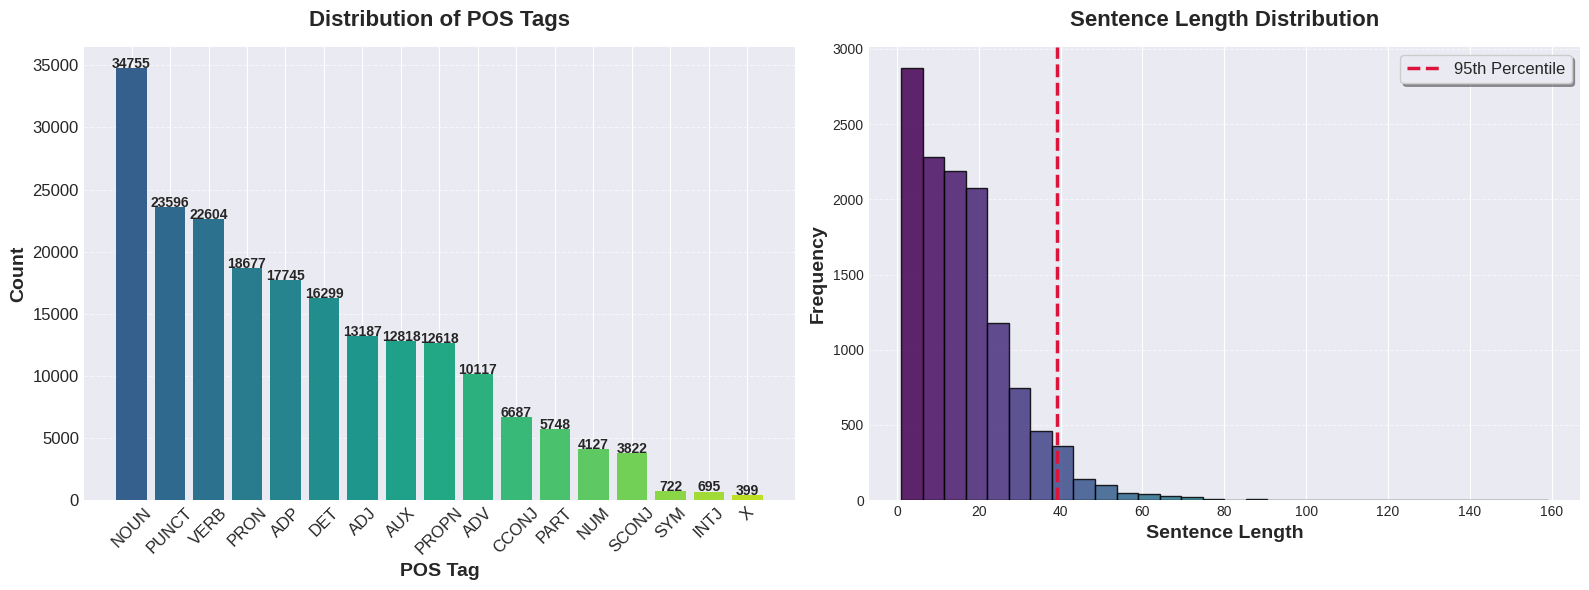


Max sentence length (95th percentile): 39
Training dataset size: 12544
Validation dataset size: 2001
Test dataset size: 2077


In [3]:
import numpy as np
import pandas as pd
import requests
import fasttext
import fasttext.util
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Download & Process CoNLL-U Data
# -------------------------------

def download_and_read_conllu(url):
    """
    Downloads and processes a CoNLL-U formatted file.
    Extracts words and POS tags from each sentence and stores them in a DataFrame.
    """
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    data = []
    sentence, pos_tags = [], []

    for line in response.text.split("\n"):
        line = line.strip()

        # Empty line indicates the end of a sentence
        if not line:
            if sentence:
                data.append({'Sentence': sentence, 'POS_Tags': pos_tags})
                sentence, pos_tags = [], []  # Reset for the next sentence
            continue

        # Ignore comment lines
        if line.startswith('#'):
            continue

        tokens = line.split('\t')
        if len(tokens) > 3:
            word, pos_tag = tokens[1], tokens[3]
            if pos_tag not in {"_"}:
                sentence.append(word)
                pos_tags.append(pos_tag)

    if sentence:
        data.append({'Sentence': sentence, 'POS_Tags': pos_tags})

    return pd.DataFrame(data)

# Load the train, validation, and test datasets
train_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu"
dev_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu"
test_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"

train_df = download_and_read_conllu(train_url)
dev_df = download_and_read_conllu(dev_url)
test_df = download_and_read_conllu(test_url)

print(f"Loaded {len(train_df)} training sentences")
print(f"Loaded {len(dev_df)} validation sentences")
print(f"Loaded {len(test_df)} test sentences")

# -------------------------------
# Step 1: Plot Distribution of POS Tags and Length of Setences
# -------------------------------
from collections import Counter

# Flatten the list of POS tags from all rows
all_pos_tags = [tag for sublist in train_df['POS_Tags'] for tag in sublist]

# Count occurrences of each POS tag
pos_counts = Counter(all_pos_tags)

# Sort counts in descending order for better visualization
sorted_pos_counts = dict(sorted(pos_counts.items(), key=lambda item: item[1], reverse=True))

# Compute sentence lengths
sentence_lengths = [len(sentence) for sentence in train_df["Sentence"]]

# Apply a stylish theme
plt.style.use('seaborn-v0_8-darkgrid')

# Create a figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: POS Tag Distribution ---
axes[0].bar(sorted_pos_counts.keys(), sorted_pos_counts.values(),
            color=plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_pos_counts))))

axes[0].set_xlabel("POS Tag", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Count", fontsize=14, fontweight='bold')
axes[0].set_title("Distribution of POS Tags", fontsize=16, fontweight='bold', pad=15)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Show the values on top of bars
for i, (key, value) in enumerate(sorted_pos_counts.items()):
    axes[0].text(i, value + 5, str(value), ha='center', fontsize=10, fontweight='bold')

# --- Plot 2: Sentence Length Distribution ---
n, bins, patches = axes[1].hist(sentence_lengths, bins=30, edgecolor='black', alpha=0.85)

# Apply a colormap to bars
cmap = plt.cm.viridis
for i, patch in enumerate(patches):
    color = cmap(i / len(patches))  # Gradient effect
    patch.set_facecolor(color)

# Add a percentile line
percentile_95 = np.percentile(sentence_lengths, 95)
axes[1].axvline(percentile_95, color='crimson', linestyle='dashed', linewidth=2.5, label="95th Percentile")

# Improve Labels & Title
axes[1].set_xlabel("Sentence Length", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Frequency", fontsize=14, fontweight='bold')
axes[1].set_title("Sentence Length Distribution", fontsize=16, fontweight='bold', pad=15)

# Customize the legend
axes[1].legend(fontsize=12, loc="upper right", frameon=True, shadow=True, fancybox=True)

# Fine-tune grid appearance
axes[1].grid(axis='y', linestyle='--', alpha=0.6, linewidth=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plots
plt.show()

# -------------------------------
# Step 2: Create Vocabulary & Embeddings
# -------------------------------

# Create word and POS tag vocabularies
all_words = set(word.lower() for sentence in train_df["Sentence"] for word in sentence)
all_pos_tags = set(tag for tags in train_df["POS_Tags"] for tag in tags)

# Word vocabulary with 'PAD' and 'UNK'
word_vocab = {'PAD': 0, 'UNK': 1}
word_vocab.update({word: idx + 2 for idx, word in enumerate(all_words)})

# POS vocabulary with 'PAD'
pos_vocab = {'PAD': 0}
pos_vocab.update({tag: idx + 1 for idx, tag in enumerate(all_pos_tags)})

# Load FastText embeddings
fasttext.util.download_model('en', if_exists='ignore')
ft_model = fasttext.load_model('cc.en.300.bin')

# Initialize the embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(word_vocab), embedding_dim))

for word, idx in word_vocab.items():
    if word in ft_model:
        embedding_matrix[idx] = ft_model[word]
    elif idx > 1:
        embedding_matrix[idx] = np.random.uniform(-0.1, 0.1, embedding_dim)

# Cleanup FastText model
del ft_model

# -------------------------------
# Step 3: Prepare Dataset & DataLoader
# -------------------------------

class POSTaggingDataset(Dataset):
    """
    PyTorch Dataset for POS tagging.
    Converts sentences into indexed tensors using the word and POS vocabularies.
    """

    def __init__(self, sentences, pos_tags, word_vocab, pos_vocab, max_length):
        self.sentences = [self.tokenize(sentence, word_vocab, max_length) for sentence in sentences]
        self.pos_tags = [self.tokenize_pos(tags, pos_vocab, max_length) for tags in pos_tags]

    def tokenize(self, sentence, vocab, max_length):
        """
        Converts words to indices, pads or truncates to max_length.
        """
        tokens = [vocab.get(word.lower(), vocab['UNK']) for word in sentence]
        tokens = tokens[:max_length] + [vocab['PAD']] * max(0, max_length - len(tokens))
        return tokens

    def tokenize_pos(self, pos_tags, vocab, max_length):
        """
        Converts POS tags to indices, pads or truncates to max_length.
        """
        tokens = [vocab.get(tag, vocab['PAD']) for tag in pos_tags]
        tokens = tokens[:max_length] + [vocab['PAD']] * max(0, max_length - len(tokens))
        return tokens

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx]), torch.tensor(self.pos_tags[idx])

# Determine max sentence length using the 95th percentile
max_length = int(np.percentile([len(sentence) for sentence in train_df["Sentence"]], 95))
print(f"Max sentence length (95th percentile): {max_length}")

# Create dataset objects
train_dataset = POSTaggingDataset(train_df["Sentence"], train_df["POS_Tags"], word_vocab, pos_vocab, max_length)
val_dataset = POSTaggingDataset(dev_df["Sentence"], dev_df["POS_Tags"], word_vocab, pos_vocab, max_length)
test_dataset = POSTaggingDataset(test_df["Sentence"], test_df["POS_Tags"], word_vocab, pos_vocab, max_length)

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


- We can observe an imbalance in POS tagging distribution e.g. noun are dominat in frequency compared to SYM.
- In addition, regarding setence legth the majority of setences have until 39 tokens, wotds.
    - This numbes is mentioned as threshols.
    - In the case of some setences having more tokes (words), we truncated them as we have already mentioned above.
- We also have 12544 training instances for training set, 2001 for devset and 2077 for test set.

In [4]:
train_loader

In [5]:
print("POS Vocabulary Mapping:", pos_vocab) # preview POS mapping


POS Vocabulary Mapping: {'PAD': 0, 'SYM': 1, 'NUM': 2, 'DET': 3, 'PUNCT': 4, 'SCONJ': 5, 'PART': 6, 'ADJ': 7, 'PROPN': 8, 'NOUN': 9, 'ADP': 10, 'PRON': 11, 'ADV': 12, 'CCONJ': 13, 'VERB': 14, 'X': 15, 'AUX': 16, 'INTJ': 17}


- Above we can observe what each integer represents meaning what part of speech (POS).
    - With exception thefirst one which will be ignored.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
num_pos_tags = len(pos_vocab)  # Number of POS tag classes
num_pos_tags

18

# POSCNNModel: A CNN-Based POS Tagging Model with Attention

- `POSCNNModel` is a PyTorch-based neural network for **part-of-speech (POS) tagging**, leveraging **convolutional layers** and an **attention mechanism** to predict POS tags per token in a sentence.

- Key Features
- **Embedding Layer**: Supports pretrained embeddings with optional freezing.
- **Convolutional Layers**: Extracts local features from token embeddings.
- **Attention Mechanism**: Focuses on important tokens using learned attention weights.
- **Fully Connected Layer**: Maps extracted features to POS tag probabilities.
- **Dropout Regularization**: Prevents overfitting in embedding, CNN, and attention layers.

- Input & Output
- **Input**: `(batch_size, sequence_length)`, where each token is an index.
- **Output**: `(batch_size, sequence_length, num_pos_tags)`, where each token gets a POS tag prediction.

- Functionality
1. Embeds input tokens using `nn.Embedding`.
2. Passes embeddings through stacked **1D CNN layers** with ReLU activation.
3. Applies **attention** to highlight important token features.
4. Generates per-token POS tag predictions using `nn.Linear`.


----

## MultiFilterCNN_POS: CNN-based POS Tagging Model

- Overview
MultiFilterCNN_POS is a **convolutional neural network (CNN)** designed for **Part-of-Speech (POS) tagging** or **sequence labeling** tasks.

- Features
- **Multi-filter CNN**: Uses **bigram (2-gram), trigram (3-gram), and fourgram (4-gram) convolutions** to capture local context.
- **Pretrained Embeddings Support**: Can load word embeddings (e.g., GloVe, Word2Vec).
- **Residual Connections**: Helps retain information across layers.
- **Dropout Regularization**: Applied at multiple layers to prevent overfitting.
- **Optional Attention Mechanism**: Enhances feature importance weighting.

- Architecture
1. **Embedding Layer**: Converts words into dense vector representations.
2. **CNN Layers**: Extract n-gram features using multiple convolutional filters.
3. **Dropout & Residual Connections**: Improve generalization and stability.
4. **Fully Connected Layer**: Maps extracted features to output classes (POS tags).
5. **Attention Layer**: Assigns importance weights to different tokens.
6. **Final Output**: Produces **per-token classification** `(batch_size, sequence_length, num_classes)`.


- We don't implemented pooling as it is POS task prediction per token.

- Note  : CrossEntropyLoss expects raw logits and automatically applies log_softmax so this is the reason why we did not defined it manually.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F

class POSCNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, kernel_size, output_dim,
                 attention_dim, pretrained=True, freeze=False, num_layers=1,
                 use_attention=True, dropout_rate=0.3):
        super(POSCNNModel, self).__init__()

        assert use_attention, "Attention must be used"
        assert attention_dim is not None, "Attention dimension must be specified"

        # Embedding Layer with Optional Pretrained Weights
        if pretrained:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0).from_pretrained(
                torch.tensor(embedding_matrix, dtype=torch.float32), freeze=freeze
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embedding_dropout = nn.Dropout(p=dropout_rate)

        # CNN Layers
        self.conv_layers = nn.ModuleList()
        for layer_idx in range(num_layers):
            in_channels = embed_dim if layer_idx == 0 else num_filters
            self.conv_layers.append(nn.Conv1d(in_channels, num_filters, kernel_size, padding='same'))

        self.conv_dropout = nn.Dropout(p=dropout_rate)

        # Attention Mechanism
        self.attention_mlp = nn.Sequential(
            nn.Linear(num_filters, attention_dim),
            nn.Tanh(),
            nn.Linear(attention_dim, 1)
        )
        self.attention_dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(num_filters, output_dim)

    def forward(self, x):
        """
        x: (batch_size, sequence_length)
        Output: (batch_size, sequence_length, num_pos_tags)
        """
        z = self.embedding(x)  # (batch_size, sequence_length, embed_dim)
        z = self.embedding_dropout(z)
        z = z.transpose(1, 2)  # Convert to (batch_size, embed_dim, sequence_length) for Conv1D

        for layer_idx in range(len(self.conv_layers)):
            z = self.conv_layers[layer_idx](z)
            z = F.relu(z)
            z = self.conv_dropout(z)

        # Attention mechanism
        z = z.transpose(1, 2)  # (batch_size, sequence_length, num_filters)
        attention_weights = self.attention_mlp(z)  # (batch_size, sequence_length, 1)
        padding_mask = (x == 0).unsqueeze(-1).float()
        attention_weights -= 1e6 * padding_mask  # Mask out padding tokens
        attention_weights = torch.softmax(attention_weights, dim=1)
        attention_output = z * attention_weights  # (batch_size, sequence_length, num_filters)
        attention_output = self.attention_dropout(attention_output)
        pos_output = self.fc(attention_output)  # (batch_size, sequence_length, num_pos_tags)
        return pos_output



In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiFilterCNN_POS(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, attention_dim=None,
                 num_filters=100, pretrained_embeddings=True, freeze_embeddings=False,
                 num_layers=1, use_attention=False, dropout_rate=0.3):
        super(MultiFilterCNN_POS, self).__init__()
        self.use_attention = use_attention
        self.attention_mlp = None
        self.dropout_rate = dropout_rate

        # Embedding Layer
        if pretrained_embeddings:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0).from_pretrained(
                torch.tensor(embedding_matrix, dtype=torch.float32), freeze=freeze_embeddings
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.embedding_dropout = nn.Dropout(p=dropout_rate)
        self.embeddings_projection = nn.Linear(embed_dim, num_filters)

        # CNN layers for n-grams
        self.bigram_layers = nn.ModuleList()
        self.trigram_layers = nn.ModuleList()
        self.fourgram_layers = nn.ModuleList()
        self.conv_dropout = nn.Dropout(p=dropout_rate)

        for _ in range(num_layers):
            in_channels = num_filters
            self.bigram_layers.append(nn.Conv1d(in_channels, num_filters, kernel_size=2, padding=1))
            self.trigram_layers.append(nn.Conv1d(in_channels, num_filters, kernel_size=3, padding=1))
            self.fourgram_layers.append(nn.Conv1d(in_channels, num_filters, kernel_size=4, padding=2))

        # Fully Connected Layer
        self.fc = nn.Linear(num_filters * 3, num_classes)

        # Attention mechanism (if enabled)
        if self.use_attention:
            assert attention_dim is not None, "Attention dimension must be specified"
            self.attention_mlp = nn.Sequential(
                nn.Linear(num_filters * 3, attention_dim),
                nn.Tanh(),
                nn.Linear(attention_dim, 1)
            )

    def forward(self, x):
        z = self.embedding(x)  # (batch_size, sequence_length, embed_dim)
        z = self.embedding_dropout(z)
        z = self.embeddings_projection(z)  # (batch_size, sequence_length, num_filters)

        # Transpose for Conv1d (batch_size, in_channels, sequence_length)
        z = z.transpose(1, 2)

        # Residual connections
        bigram, residual_bigram = z, z
        trigram, residual_trigram = z, z
        fourgram, residual_fourgram = z, z

        for bigram_layer, trigram_layer, fourgram_layer in zip(self.bigram_layers, self.trigram_layers, self.fourgram_layers):
            bigram_out = F.relu(bigram_layer(bigram))
            trigram_out = F.relu(trigram_layer(trigram))
            fourgram_out = F.relu(fourgram_layer(fourgram))

            # Ensure output sizes match the expected sequence length
            min_seq_len = min(bigram_out.shape[2], trigram_out.shape[2], fourgram_out.shape[2])
            bigram_out = bigram_out[:, :, :min_seq_len]
            trigram_out = trigram_out[:, :, :min_seq_len]
            fourgram_out = fourgram_out[:, :, :min_seq_len]

            # Apply dropout
            bigram_out = self.conv_dropout(bigram_out)
            trigram_out = self.conv_dropout(trigram_out)
            fourgram_out = self.conv_dropout(fourgram_out)

            # Ensure sizes match before residual connections
            if bigram_out.shape == residual_bigram.shape:
                bigram = bigram_out + 0.5 * residual_bigram
            else:
                bigram = bigram_out

            if trigram_out.shape == residual_trigram.shape:
                trigram = trigram_out + 0.5 * residual_trigram
            else:
                trigram = trigram_out

            if fourgram_out.shape == residual_fourgram.shape:
                fourgram = fourgram_out + 0.5 * residual_fourgram
            else:
                fourgram = fourgram_out

            residual_bigram, residual_trigram, residual_fourgram = bigram, trigram, fourgram

        # Ensure all outputs have the same sequence length
        min_seq_len = min(bigram.shape[2], trigram.shape[2], fourgram.shape[2])
        bigram = bigram[:, :, :min_seq_len]
        trigram = trigram[:, :, :min_seq_len]
        fourgram = fourgram[:, :, :min_seq_len]

        # Concatenate multi-filter outputs
        output = torch.cat((bigram, trigram, fourgram), dim=1).transpose(1, 2)  # (batch_size, sequence_length, num_filters * 3)

        if self.use_attention:
            attention_weights = self.attention_mlp(output)  # (batch_size, sequence_length, 1)
            attention_weights = torch.softmax(attention_weights, dim=1)
            output = output * attention_weights  # Weighted sum
            return self.fc(output)  # (batch_size, sequence_length, num_classes)

        return self.fc(output)  # Default: per-token classification

### **Training Function Plotting both Losses and AVG Macro F1-Score for the scope of tuning**



### T**uning Stage : Investigation of Promising Hyperparameters**.
- In order to decide the "most" promising combination of hyperparameters we check 3 diamensions :     
1. **Loss** Plot of training - dev sets we want a) the lowest loss values (predictions closest to actual data) b) the lowest gap (in order to avoid overfitting phenomenos)
2. We monitor **macro f1 score** as an indicator of good predictions. We want high values for better predictions.


- Structure of this Section:
    - at the beggining we will leverage the functioanlities offeres by the class `POSCNNModel`
    - then we will leverage the functionalitied offered by `MultiFilterCNN`

In [10]:
from sklearn.metrics import f1_score

- Note: During training we ignore padding from evaluations metric (f1-score).

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=5, device='cuda'):
    train_losses, val_losses = [], []
    train_f1_scores, val_f1_scores = [], []
    best_val_loss = float('inf')
    best_model_path = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_true_train, y_pred_train = [], []

        for sentences, pos_tags in train_loader:
            optimizer.zero_grad()
            sentences, pos_tags = sentences.to(device), pos_tags.to(device)
            outputs = model(sentences)
            loss = criterion(outputs.permute(0, 2, 1), pos_tags)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = torch.argmax(outputs, dim=2)
            for true_tags, pred_tags in zip(pos_tags.cpu().tolist(), preds.cpu().tolist()):
                for t, p in zip(true_tags, pred_tags):
                    if t != 0:
                        y_true_train.append(t)
                        y_pred_train.append(p)

        train_losses.append(train_loss / len(train_loader))
        train_f1_scores.append(f1_score(y_true_train, y_pred_train, average='macro', zero_division=0))

        model.eval()
        val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for sentences, pos_tags in val_loader:
                sentences, pos_tags = sentences.to(device), pos_tags.to(device)
                outputs = model(sentences)
                loss = criterion(outputs.permute(0, 2, 1), pos_tags)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=2)
                for true_tags, pred_tags in zip(pos_tags.cpu().tolist(), preds.cpu().tolist()):
                    for t, p in zip(true_tags, pred_tags):
                        if t != 0:
                            y_true_val.append(t)
                            y_pred_val.append(p)

        val_losses.append(val_loss / len(val_loader))
        val_f1_scores.append(f1_score(y_true_val, y_pred_val, average='macro', zero_division=0))

        print(f'Epoch {epoch+1}/{epochs} | Training Loss: {train_losses[-1]:.5f}, Validation Loss: {val_losses[-1]:.5f}, F1-Macro Train: {train_f1_scores[-1]:.5f}, F1-Macro Dev: {val_f1_scores[-1]:.5f}')

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            new_model_path = f'pos_cnn_best_model_epoch_{epoch+1}.pth'
            if best_model_path is not None:
                os.remove(best_model_path)
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. No improvement in validation loss for {patience} consecutive epochs.")
            break

    return train_losses, val_losses, train_f1_scores, val_f1_scores


- Below we will make some experiments with the below defined configurations for the first class that is POSCNNModel.


Training with Baseline
Training POS tagging model...
Epoch 1/200 | Training Loss: 2.03293, Validation Loss: 1.37619, F1-Macro Train: 0.17506, F1-Macro Dev: 0.32276
Epoch 2/200 | Training Loss: 1.14755, Validation Loss: 0.80674, F1-Macro Train: 0.41081, F1-Macro Dev: 0.49806
Epoch 3/200 | Training Loss: 0.72283, Validation Loss: 0.63607, F1-Macro Train: 0.55373, F1-Macro Dev: 0.65329
Epoch 4/200 | Training Loss: 0.51159, Validation Loss: 0.55130, F1-Macro Train: 0.68368, F1-Macro Dev: 0.72138
Epoch 5/200 | Training Loss: 0.38029, Validation Loss: 0.47327, F1-Macro Train: 0.73752, F1-Macro Dev: 0.75314
Epoch 6/200 | Training Loss: 0.29919, Validation Loss: 0.46791, F1-Macro Train: 0.77969, F1-Macro Dev: 0.78505
Epoch 7/200 | Training Loss: 0.26114, Validation Loss: 0.47029, F1-Macro Train: 0.81493, F1-Macro Dev: 0.79532
Epoch 8/200 | Training Loss: 0.23479, Validation Loss: 0.47281, F1-Macro Train: 0.83209, F1-Macro Dev: 0.80060
Epoch 9/200 | Training Loss: 0.21275, Validation Loss: 0.4

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


Epoch 1/200 | Training Loss: 2.38154, Validation Loss: 1.86223, F1-Macro Train: 0.09351, F1-Macro Dev: 0.15802
Epoch 2/200 | Training Loss: 1.80852, Validation Loss: 1.53019, F1-Macro Train: 0.18348, F1-Macro Dev: 0.21805
Epoch 3/200 | Training Loss: 1.49753, Validation Loss: 1.19511, F1-Macro Train: 0.27137, F1-Macro Dev: 0.36743
Epoch 4/200 | Training Loss: 1.24230, Validation Loss: 0.94526, F1-Macro Train: 0.35305, F1-Macro Dev: 0.42853
Epoch 5/200 | Training Loss: 1.04670, Validation Loss: 0.85076, F1-Macro Train: 0.40065, F1-Macro Dev: 0.45335
Epoch 6/200 | Training Loss: 0.93794, Validation Loss: 0.78828, F1-Macro Train: 0.46256, F1-Macro Dev: 0.51779
Epoch 7/200 | Training Loss: 0.85863, Validation Loss: 0.73502, F1-Macro Train: 0.51929, F1-Macro Dev: 0.58197
Epoch 8/200 | Training Loss: 0.78677, Validation Loss: 0.68088, F1-Macro Train: 0.55823, F1-Macro Dev: 0.61338
Epoch 9/200 | Training Loss: 0.73097, Validation Loss: 0.65508, F1-Macro Train: 0.58370, F1-Macro Dev: 0.63416
E

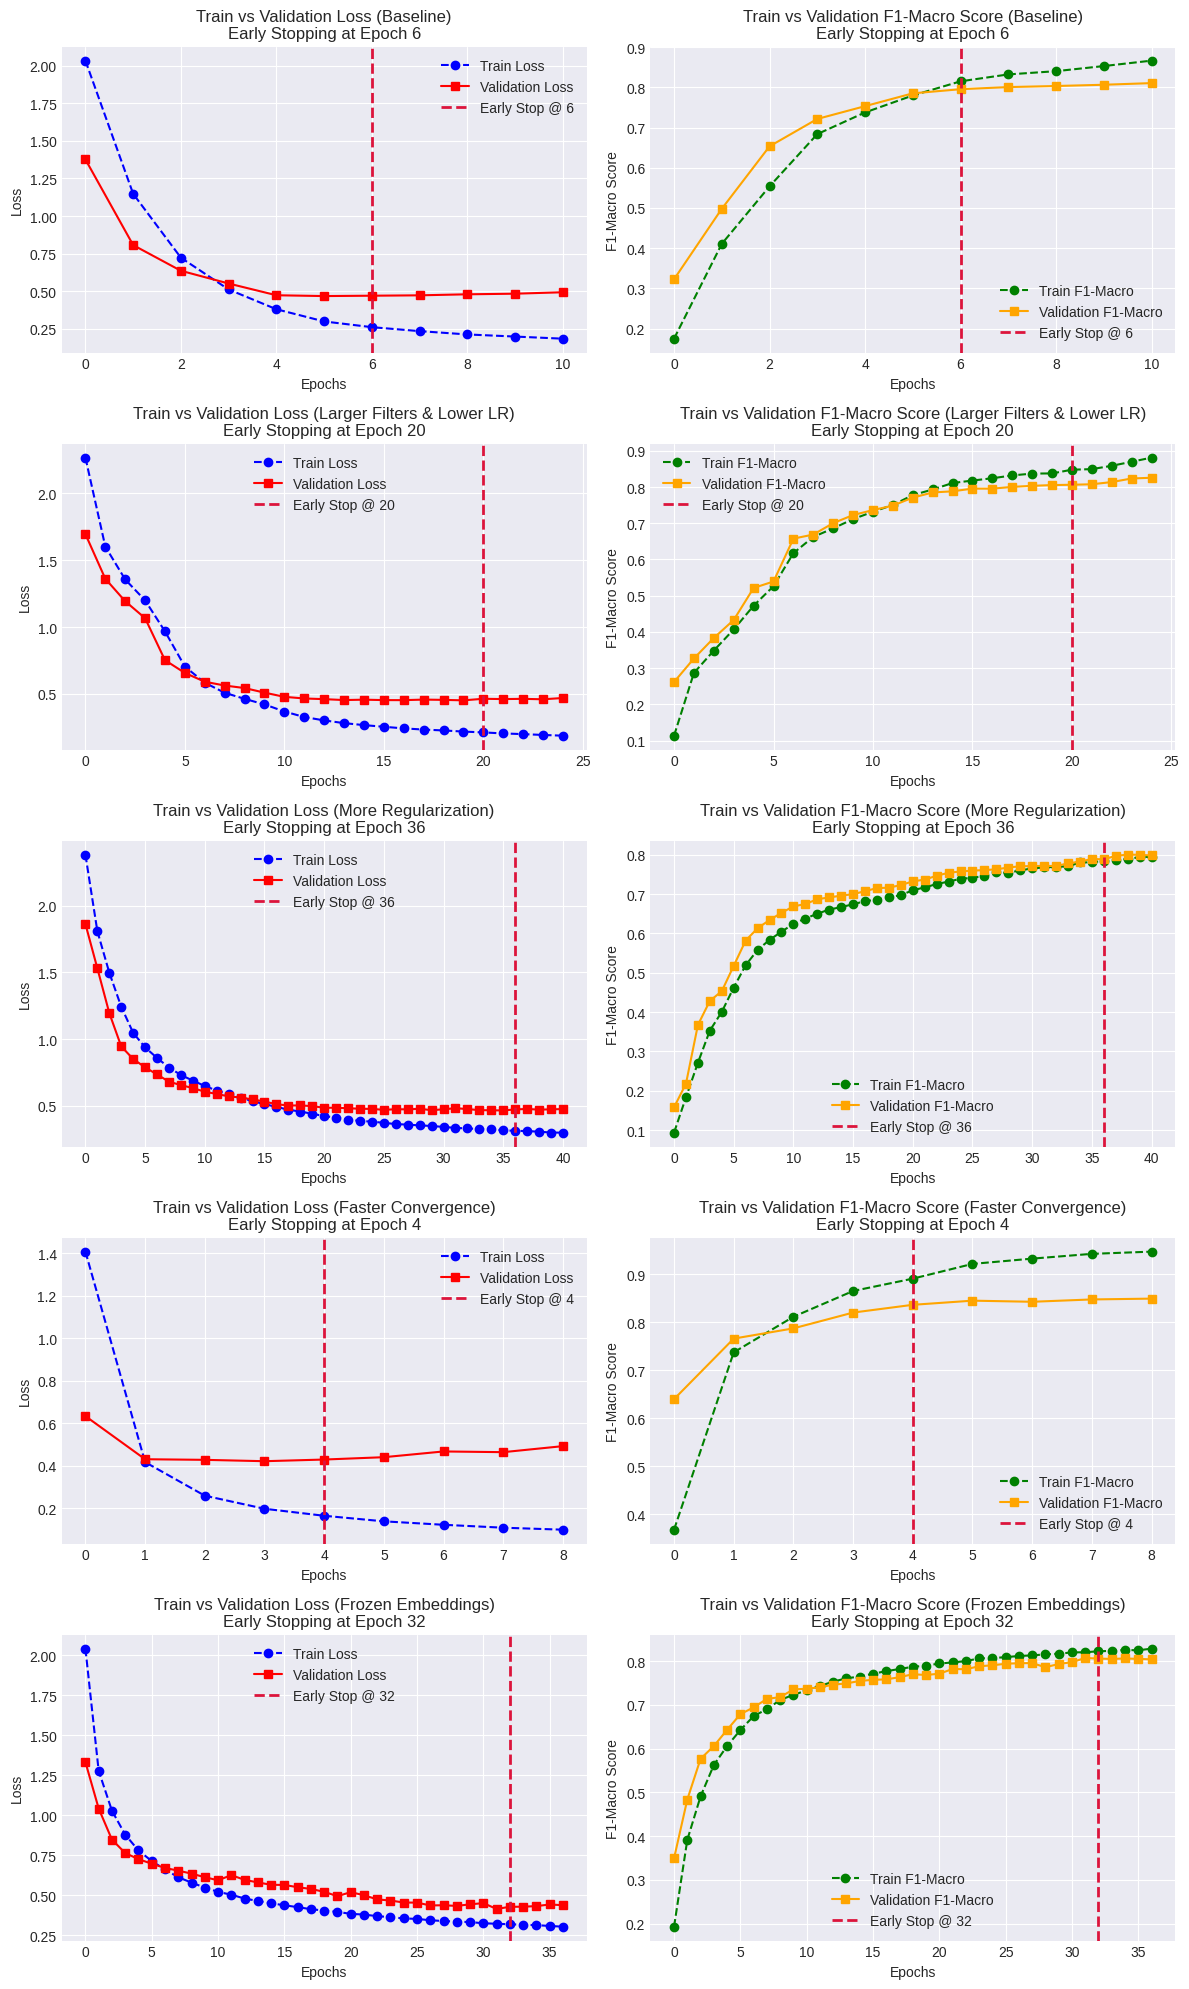

,config,best_epoch,best_val_loss,train_loss_at_best_epoch,val_f1_at_best_epoch,train_f1_at_best_epoch,loss_gap_at_best_epoch,f1_gap_at_best_epoch
0,Baseline,6,0.467910,0.299188,0.785046,0.779693,-0.168722,-0.005353
1,Larger Filters & Lower LR,20,0.451775,0.218237,0.805308,0.837503,-0.233538,0.032196
2,More Regularization,36,0.465341,0.317035,0.789473,0.781074,-0.148306,-0.008399
3,Faster Convergence,4,0.421996,0.198128,0.819830,0.864720,-0.223868,0.044890
4,Frozen Embeddings,32,0.413807,0.321167,0.807231,0.820322,-0.092640,0.013091


In [12]:
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score

# Number of POS tags
num_pos_tags = len(pos_vocab)

# Define different configurations
configs = [
    {
        "name": "Baseline",
        "num_filters": 128,
        "kernel_size": 3,
        "dropout_rate": 0.3,
        "learning_rate": 0.0005,
        "weight_decay": 1e-5,
        "step_size": 5,
        "gamma": 0.8,
        "freeze": False,
        "use_attention": True,
        "num_layers": 2
    },
    {
        "name": "Larger Filters & Lower LR",
        "num_filters": 256,
        "kernel_size": 3,
        "dropout_rate": 0.4,
        "learning_rate": 0.0002,
        "weight_decay": 5e-5,
        "step_size": 8,
        "gamma": 0.85,
        "freeze": False,
        "use_attention": True,
        "num_layers": 2
    },
    {
        "name": "More Regularization",
        "num_filters": 128,
        "kernel_size": 4,
        "dropout_rate": 0.5,
        "learning_rate": 0.0003,
        "weight_decay": 1e-4,
        "step_size": 6,
        "gamma": 0.75,
        "freeze": False,
        "use_attention": True,
        "num_layers": 2
    },
    {
        "name": "Faster Convergence",
        "num_filters": 256,
        "kernel_size": 3,
        "dropout_rate": 0.25,
        "learning_rate": 0.0008,
        "weight_decay": 1e-5,
        "step_size": 4,
        "gamma": 0.9,
        "freeze": False,
        "use_attention": True,
        "num_layers": 2
    },
     {
        "name": "Frozen Embeddings",
        "num_filters": 128,
        "kernel_size": 3,
        "dropout_rate": 0.3,
        "learning_rate": 0.0005,
        "weight_decay": 1e-5,
        "step_size": 5,
        "gamma": 0.8,
        "freeze": True,  # Freeze embeddings
        "use_attention": True,
        "num_layers": 3
    }
]

# Store results
results = []
all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []
early_stopping_epochs = []

# Train and evaluate each configuration
for config in configs:
    print(f"\nTraining with {config['name']}")

    # Instantiate the model
    pos_model = POSCNNModel(
        vocab_size=len(word_vocab),
        embed_dim=300,
        num_filters=config["num_filters"],
        kernel_size=config["kernel_size"],
        output_dim=num_pos_tags,
        attention_dim=32,
        pretrained=True, # manually defiend always use pretrained embeddigns
        freeze=config["freeze"],
        num_layers=config["num_layers"],
        use_attention=config["use_attention"],
        dropout_rate=config["dropout_rate"]
    ).to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss(ignore_index=pos_vocab['PAD'])

    # Optimizer
    optimizer = optim.Adam(pos_model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

    # Training parameters
    epochs = 200
    patience = 5

    print("Training POS tagging model...")

    # Train the model
    train_losses, val_losses, train_f1_scores, val_f1_scores = train_model(
        model=pos_model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=epochs,
        device=device,
        patience=patience
    )

    # Find the best epoch (early stopping point)
    best_epoch = np.argmin(val_losses) + 1
    best_val_loss = min(val_losses)
    early_stopping_epochs.append(best_epoch)

    # Get training loss and F1 at the best epoch
    train_loss_at_best_epoch = train_losses[best_epoch - 1]
    val_f1_at_best_epoch = val_f1_scores[best_epoch - 1]
    train_f1_at_best_epoch = train_f1_scores[best_epoch - 1]

    print(f"{config['name']} - Best Epoch: {best_epoch}, Validation Loss: {best_val_loss:.5f}")

    # Store results
    results.append({
        "config": config["name"],
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
        "train_loss_at_best_epoch": train_loss_at_best_epoch,
        "val_f1_at_best_epoch": val_f1_at_best_epoch,
        "train_f1_at_best_epoch": train_f1_at_best_epoch,
    })

    # Store plots data for later visualization
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_f1.append(train_f1_scores)
    all_val_f1.append(val_f1_scores)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Compute the gap between training and validation losses at the best epoch
results_df["loss_gap_at_best_epoch"] = results_df["train_loss_at_best_epoch"] - results_df["best_val_loss"]

# Compute the gap between training and validation F1 scores at the best epoch
results_df["f1_gap_at_best_epoch"] = results_df["train_f1_at_best_epoch"] - results_df["val_f1_at_best_epoch"]

# **Plot all configurations in one figure**
fig, axes = plt.subplots(len(configs), 2, figsize=(12, 4 * len(configs)))

for i, config in enumerate(configs):
    stopping_epoch = early_stopping_epochs[i]

    # Plot Losses
    axes[i, 0].plot(all_train_losses[i], linestyle='--', marker='o', label='Train Loss', color='blue')
    axes[i, 0].plot(all_val_losses[i], marker='s', label='Validation Loss', color='red')
    axes[i, 0].axvline(stopping_epoch, color='crimson', linestyle='dashed', linewidth=2, label=f"Early Stop @ {stopping_epoch}")
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].set_title(f'Train vs Validation Loss ({config["name"]})\nEarly Stopping at Epoch {stopping_epoch}')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Plot F1-Macro Scores
    axes[i, 1].plot(all_train_f1[i], linestyle='--', marker='o', label='Train F1-Macro', color='green')
    axes[i, 1].plot(all_val_f1[i], marker='s', label='Validation F1-Macro', color='orange')
    axes[i, 1].axvline(stopping_epoch, color='crimson', linestyle='dashed', linewidth=2, label=f"Early Stop @ {stopping_epoch}")
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('F1-Macro Score')
    axes[i, 1].set_title(f'Train vs Validation F1-Macro Score ({config["name"]})\nEarly Stopping at Epoch {stopping_epoch}')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

results_df


- We above observe the trend in losses function in train dev set.
    - We check the value and the gap as we have already mentioned.
- For helping, we also generated a pandas df representing the numbers related to losses gapa (we face negative numbers in the diffrence the gap), and fi scores again with their gaps in train and dev set similarly.
- We want low losses , figh f1 score and low gap in losses as we have already mentioned.

- Now we will move on experimenting combinations in the other class being MultiFilterCNN_POS.


Training with Baseline
Training POS tagging model...
Epoch 1/200 | Training Loss: 1.67499, Validation Loss: 0.87786, F1-Macro Train: 0.26939, F1-Macro Dev: 0.43799
Epoch 2/200 | Training Loss: 0.53087, Validation Loss: 0.42170, F1-Macro Train: 0.65547, F1-Macro Dev: 0.71577
Epoch 3/200 | Training Loss: 0.27691, Validation Loss: 0.35764, F1-Macro Train: 0.78596, F1-Macro Dev: 0.80325
Epoch 4/200 | Training Loss: 0.20931, Validation Loss: 0.33877, F1-Macro Train: 0.85923, F1-Macro Dev: 0.81900
Epoch 5/200 | Training Loss: 0.18020, Validation Loss: 0.33539, F1-Macro Train: 0.88216, F1-Macro Dev: 0.82897
Epoch 6/200 | Training Loss: 0.16060, Validation Loss: 0.33019, F1-Macro Train: 0.89485, F1-Macro Dev: 0.83570
Epoch 7/200 | Training Loss: 0.14664, Validation Loss: 0.33310, F1-Macro Train: 0.90365, F1-Macro Dev: 0.83533
Epoch 8/200 | Training Loss: 0.13586, Validation Loss: 0.33869, F1-Macro Train: 0.91187, F1-Macro Dev: 0.83679
Epoch 9/200 | Training Loss: 0.12764, Validation Loss: 0.3

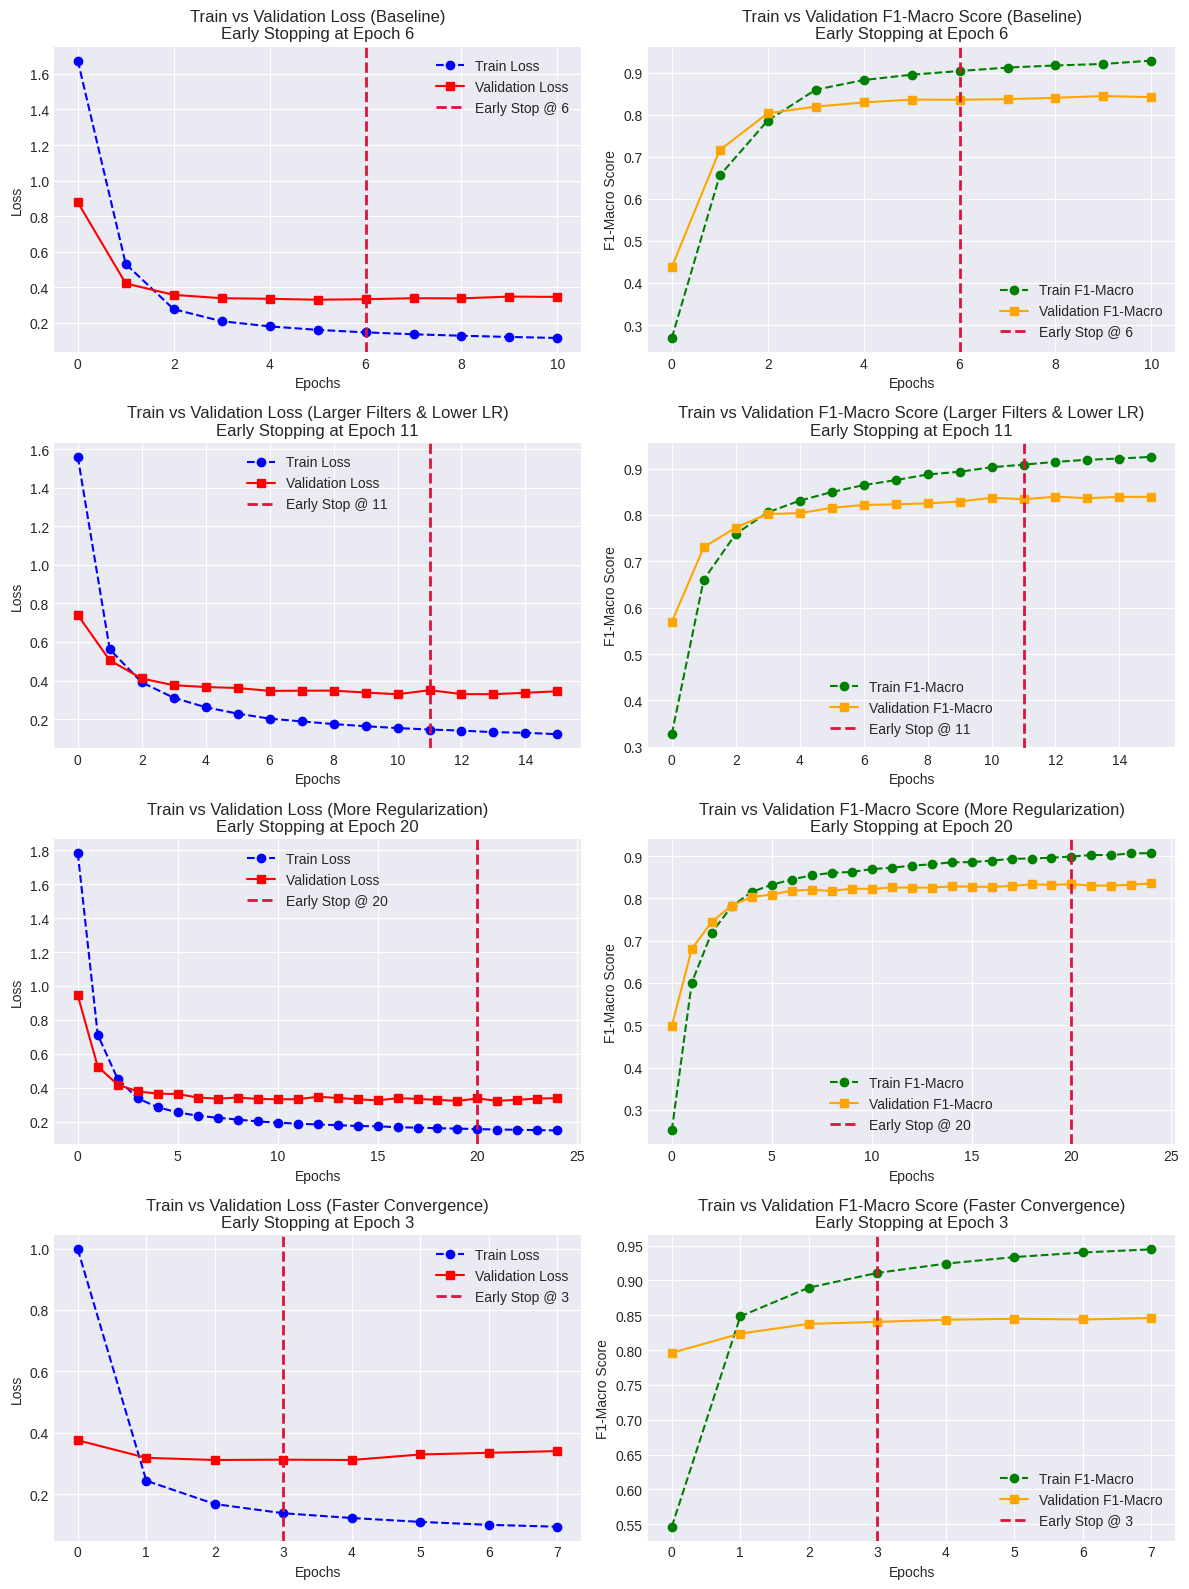

,config,best_epoch,best_val_loss,train_loss_at_best_epoch,val_f1_at_best_epoch,train_f1_at_best_epoch,loss_gap_at_best_epoch,f1_gap_at_best_epoch
0,Baseline,6,0.330192,0.160603,0.835699,0.894846,-0.169589,0.059148
1,Larger Filters & Lower LR,11,0.328801,0.153547,0.837001,0.902755,-0.175254,0.065754
2,More Regularization,20,0.323561,0.160681,0.831870,0.896272,-0.162881,0.064403
3,Faster Convergence,3,0.310871,0.167297,0.837661,0.889682,-0.143574,0.052021


In [13]:
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

# Number of POS tags
num_pos_tags = len(pos_vocab)

# Define different configurations
configs = [
    {
        "name": "Baseline",
        "num_filters": 128,
        "dropout_rate": 0.3,
        "learning_rate": 0.0005,
        "weight_decay": 1e-5,
        "step_size": 5,
        "gamma": 0.8,
         "num_layers" : 1
    },
    {
        "name": "Larger Filters & Lower LR",
        "num_filters": 256,
        "dropout_rate": 0.4,
        "learning_rate": 0.0002,
        "weight_decay": 5e-5,
        "step_size": 8,
        "gamma": 0.85,
         "num_layers" : 3
    },
    {
        "name": "More Regularization",
        "num_filters": 128,
        "dropout_rate": 0.5,
        "learning_rate": 0.0003,
        "weight_decay": 1e-4,
        "step_size": 6,
        "gamma": 0.75,
         "num_layers" : 2
    },
    {
        "name": "Faster Convergence",
        "num_filters": 256,
        "dropout_rate": 0.25,
        "learning_rate": 0.0008,
        "weight_decay": 1e-5,
        "step_size": 4,
        "gamma": 0.9,
        "num_layers" : 1
    }

]

# Store results
results = []
all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []
early_stopping_epochs = []

# Train and evaluate each configuration
for config in configs:
    print(f"\nTraining with {config['name']}")

    # Instantiate the MultiFilterCNN_POS model
    pos_model = MultiFilterCNN_POS(
        vocab_size=len(word_vocab),
        embed_dim=300,
        num_classes=num_pos_tags,
        num_filters=config["num_filters"],
        attention_dim=32,
        pretrained_embeddings=True,
        num_layers=config["num_layers"],
        use_attention=True,
        dropout_rate=config["dropout_rate"]
        ).to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss(ignore_index=pos_vocab['PAD'])

    # Optimizer
    optimizer = optim.Adam(pos_model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

    # Training parameters
    epochs = 200
    patience = 5

    print("Training POS tagging model...")

    # Train the model
    train_losses, val_losses, train_f1_scores, val_f1_scores = train_model(
        model=pos_model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=epochs,
        device=device,
        patience=patience
    )

    # Find the best epoch (early stopping point)
    best_epoch = np.argmin(val_losses) + 1
    best_val_loss = min(val_losses)
    early_stopping_epochs.append(best_epoch)

    # Get training loss and F1 at the best epoch
    train_loss_at_best_epoch = train_losses[best_epoch - 1]
    val_f1_at_best_epoch = val_f1_scores[best_epoch - 1]
    train_f1_at_best_epoch = train_f1_scores[best_epoch - 1]

    print(f"{config['name']} - Best Epoch: {best_epoch}, Validation Loss: {best_val_loss:.5f}")

    # Store results
    results.append({
        "config": config["name"],
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
        "train_loss_at_best_epoch": train_loss_at_best_epoch,
        "val_f1_at_best_epoch": val_f1_at_best_epoch,
        "train_f1_at_best_epoch": train_f1_at_best_epoch,
    })

    # Store plots data for later visualization
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_f1.append(train_f1_scores)
    all_val_f1.append(val_f1_scores)

# Convert results to DataFrame
multi_filter_cnn_pos_results_df = pd.DataFrame(results)

# Compute the gap between training and validation losses at the best epoch
multi_filter_cnn_pos_results_df["loss_gap_at_best_epoch"] = (
    multi_filter_cnn_pos_results_df["train_loss_at_best_epoch"] - multi_filter_cnn_pos_results_df["best_val_loss"]
)

# Compute the gap between training and validation F1 scores at the best epoch
multi_filter_cnn_pos_results_df["f1_gap_at_best_epoch"] = (
    multi_filter_cnn_pos_results_df["train_f1_at_best_epoch"] - multi_filter_cnn_pos_results_df["val_f1_at_best_epoch"]
)

# **Plot all configurations in one figure**
fig, axes = plt.subplots(len(configs), 2, figsize=(12, 4 * len(configs)))

for i, config in enumerate(configs):
    stopping_epoch = early_stopping_epochs[i]

    # Plot Losses
    axes[i, 0].plot(all_train_losses[i], linestyle='--', marker='o', label='Train Loss', color='blue')
    axes[i, 0].plot(all_val_losses[i], marker='s', label='Validation Loss', color='red')
    axes[i, 0].axvline(stopping_epoch, color='crimson', linestyle='dashed', linewidth=2, label=f"Early Stop @ {stopping_epoch}")
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].set_title(f'Train vs Validation Loss ({config["name"]})\nEarly Stopping at Epoch {stopping_epoch}')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Plot F1-Macro Scores
    axes[i, 1].plot(all_train_f1[i], linestyle='--', marker='o', label='Train F1-Macro', color='green')
    axes[i, 1].plot(all_val_f1[i], marker='s', label='Validation F1-Macro', color='orange')
    axes[i, 1].axvline(stopping_epoch, color='crimson', linestyle='dashed', linewidth=2, label=f"Early Stop @ {stopping_epoch}")
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('F1-Macro Score')
    axes[i, 1].set_title(f'Train vs Validation F1-Macro Score ({config["name"]})\nEarly Stopping at Epoch {stopping_epoch}')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

# Display results table
multi_filter_cnn_pos_results_df


In [14]:
results_df

,config,best_epoch,best_val_loss,train_loss_at_best_epoch,val_f1_at_best_epoch,train_f1_at_best_epoch,loss_gap_at_best_epoch,f1_gap_at_best_epoch
0,Baseline,6,0.467910,0.299188,0.785046,0.779693,-0.168722,-0.005353
1,Larger Filters & Lower LR,20,0.451775,0.218237,0.805308,0.837503,-0.233538,0.032196
2,More Regularization,36,0.465341,0.317035,0.789473,0.781074,-0.148306,-0.008399
3,Faster Convergence,4,0.421996,0.198128,0.819830,0.864720,-0.223868,0.044890
4,Frozen Embeddings,32,0.413807,0.321167,0.807231,0.820322,-0.092640,0.013091


In [15]:
multi_filter_cnn_pos_results_df

,config,best_epoch,best_val_loss,train_loss_at_best_epoch,val_f1_at_best_epoch,train_f1_at_best_epoch,loss_gap_at_best_epoch,f1_gap_at_best_epoch
0,Baseline,6,0.330192,0.160603,0.835699,0.894846,-0.169589,0.059148
1,Larger Filters & Lower LR,11,0.328801,0.153547,0.837001,0.902755,-0.175254,0.065754
2,More Regularization,20,0.323561,0.160681,0.831870,0.896272,-0.162881,0.064403
3,Faster Convergence,3,0.310871,0.167297,0.837661,0.889682,-0.143574,0.052021


- observing the two dataframes related to the two diffeent classed we defined the best config is :
    - for the class related to multifilterCNN the config the most promising configuration across all is : `	More Regularization	`
    - That is :
        - ```bash
          "name": "More Regularization",
        "num_filters": 128,
        "dropout_rate": 0.5,
        "learning_rate": 0.0003,
        "weight_decay": 1e-4,
        "step_size": 6,
        "gamma": 0.75,
         "num_layers" : 2
        ```
- As i thas the lowest loss val, high f1 score val, low gap betwwen loss train -val and f1 score improves while loss decreases.
- **Important Note** we used this combiantion as the most promising compared with the Fast Convergenece from the seconf class with multifilter because 3 epochs may be few and because their performance is quite close comared to the metrics losses f1 score and gap in losses we choose this as has a better behaviour across epochs (simlarly for Larger Filters & Lower LR).
- As a general comnent class with multiFilterCNN seem to produce better resuls (losses are lower and f1-score are higher).

### Train And Evaluate with put most promising combination stemming from tuning

In [16]:
def plot_metrics(train_losses, val_losses, train_metrics, val_metrics):
    """
    Plots training and validation loss, as well as macro F1-score.
    """

    """
    Plots training and validation loss, as well as macro F1-score.
    """
    train_f1 = [m["macro_f1"] for m in train_metrics]
    val_f1 = [m["macro_f1"] for m in val_metrics]
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    train_f1 = [m["macro_f1"] for m in train_metrics]
    val_f1 = [m["macro_f1"] for m in val_metrics]
    # Plot losses
    axes[0].plot(train_losses, linestyle='--', marker='o', label='Train Loss', color='blue')
    axes[0].plot(val_losses, marker='s', label='Validation Loss', color='red')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train vs Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot F1-macro scores
    axes[1].plot(train_f1, linestyle='--', marker='o', label='Train F1-Macro', color='green')
    axes[1].plot(val_f1, marker='s', label='Validation F1-Macro', color='orange')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1-Macro Score')
    axes[1].set_title('Train vs Validation F1-Macro Score')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [23]:
pos_vocab # decode the labels dynamically ignoring pading label.

{'PAD': 0,
 'SYM': 1,
 'NUM': 2,
 'DET': 3,
 'PUNCT': 4,
 'SCONJ': 5,
 'PART': 6,
 'ADJ': 7,
 'PROPN': 8,
 'NOUN': 9,
 'ADP': 10,
 'PRON': 11,
 'ADV': 12,
 'CCONJ': 13,
 'VERB': 14,
 'X': 15,
 'AUX': 16,
 'INTJ': 17}

In [18]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_recall_curve, auc
import numpy as np

def compute_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    pr_auc_scores = {}
    unique_labels = np.unique(y_true)
    for label in unique_labels:
        binary_true = np.array([1 if y == label else 0 for y in y_true])
        binary_pred = np.array([1 if y == label else 0 for y in y_pred])
        prec, rec, _ = precision_recall_curve(binary_true, binary_pred)
        pr_auc_scores[label] = auc(rec, prec) if len(rec) > 1 else 0.0

    macro_pr_auc = np.mean(list(pr_auc_scores.values()))

    return {
        "class_precision": precision.tolist(),
        "class_recall": recall.tolist(),
        "class_f1": f1.tolist(),
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "pr_auc": pr_auc_scores,
        "macro_pr_auc": macro_pr_auc
    }

from sklearn.metrics import classification_report

from sklearn.metrics import classification_report

def print_metrics(metrics, y_true, y_pred, dataset_name="Dataset", label_mapping=None):
    print(f"\n----------- Prediction Scores for {dataset_name} -----------")

    # Remove padding labels (assuming 0 is padding)
    filtered_y_true = [y for y in y_true if y != 0]
    filtered_y_pred = [y for t, y in zip(y_true, y_pred) if t != 0]

    # Get sorted class labels (numeric values) and their corresponding names
    sorted_label_indices = sorted(label_mapping.values())  # [1, 2, 3, ..., 17]
    sorted_class_names = [k for k, v in sorted(label_mapping.items(), key=lambda item: item[1])]  # ['PUNCT', 'NUM', ...]

    # Print classification report
    print(classification_report(filtered_y_true, filtered_y_pred, labels=sorted_label_indices, target_names=sorted_class_names, zero_division=0))

    # Print per-class metrics (Precision, Recall, F1, AUC-PR)
    print("\nPer-Class Metrics:")
    for class_name, class_index in label_mapping.items():
        if class_index in metrics['pr_auc']:
            index = class_index - 1  # Assuming class indices start from 1 (adjust if needed)

            # Ensure no index error (default to 0.0 if index is out of bounds)
            p = metrics["class_precision"][index] if index < len(metrics["class_precision"]) else 0.0
            r = metrics["class_recall"][index] if index < len(metrics["class_recall"]) else 0.0
            f1 = metrics["class_f1"][index] if index < len(metrics["class_f1"]) else 0.0
            auc_pr = metrics['pr_auc'].get(class_index, 0.0)  # AUC-PR remains a dictionary lookup

            print(f"Class {class_name}: Precision={p:.4f}, Recall={r:.4f}, F1={f1:.4f}, AUC-PR={auc_pr:.4f}")

    # Print macro AUC-PR score
    print(f"\nMacro AUC-PR: {metrics['macro_pr_auc']:.4f}")



In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_recall_curve, auc
import numpy as np

def train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=10, patience=5, device='cuda'):
    train_losses, val_losses = [], []
    train_metrics, val_metrics, test_metrics = [], [], []
    best_val_loss = float('inf')
    best_model_path = None
    patience_counter = 0

    # **Corrected Label Mapping (String -> Integer)**
    label_mapping = {
        'SYM': 1, 'NUM': 2, 'DET': 3, 'PUNCT': 4, 'SCONJ': 5, 'PART': 6,
        'ADJ': 7, 'PROPN': 8, 'NOUN': 9, 'ADP': 10, 'PRON': 11, 'ADV': 12,
        'CCONJ': 13, 'VERB': 14, 'X': 15, 'AUX': 16, 'INTJ': 17
    }
    num_classes = len(label_mapping) + 1  # Accounting for padding if needed
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}  # Reverse mapping for reporting

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_true_train, y_pred_train = [], []

        for sentences, pos_tags in train_loader:
            optimizer.zero_grad()
            sentences, pos_tags = sentences.to(device), pos_tags.to(device)
            outputs = model(sentences)
            loss = criterion(outputs.permute(0, 2, 1), pos_tags)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = torch.argmax(outputs, dim=2)
            for true_tags, pred_tags in zip(pos_tags.cpu().tolist(), preds.cpu().tolist()):
                for t, p in zip(true_tags, pred_tags):
                    if t in label_mapping.values():  # Ensure valid labels
                        y_true_train.append(t)
                        y_pred_train.append(p)

        train_losses.append(train_loss / len(train_loader))
        train_metrics.append(compute_metrics(y_true_train, y_pred_train, num_classes))

        model.eval()
        val_loss = 0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for sentences, pos_tags in val_loader:
                sentences, pos_tags = sentences.to(device), pos_tags.to(device)
                outputs = model(sentences)
                loss = criterion(outputs.permute(0, 2, 1), pos_tags)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=2)
                for true_tags, pred_tags in zip(pos_tags.cpu().tolist(), preds.cpu().tolist()):
                    for t, p in zip(true_tags, pred_tags):
                        if t in label_mapping.values():
                            y_true_val.append(t)
                            y_pred_val.append(p)

        val_losses.append(val_loss / len(val_loader))
        val_metrics.append(compute_metrics(y_true_val, y_pred_val, num_classes))

        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_losses[-1]:.5f}, Val Loss: {val_losses[-1]:.5f}, '
              f'Train F1-Macro: {train_metrics[-1]["macro_f1"]:.5f}, '
              f'Val F1-Macro: {val_metrics[-1]["macro_f1"]:.5f}')

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            new_model_path = f'pos_best_model_epoch_{epoch+1}.pth'
            if best_model_path is not None:
                os.remove(best_model_path)
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. No improvement in validation loss for {patience} epochs.")
            break

    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    y_true_test, y_pred_test = [], []

    with torch.no_grad():
        for sentences, pos_tags in test_loader:
            sentences, pos_tags = sentences.to(device), pos_tags.to(device)
            outputs = model(sentences)
            preds = torch.argmax(outputs, dim=2)
            for true_tags, pred_tags in zip(pos_tags.cpu().tolist(), preds.cpu().tolist()):
                for t, p in zip(true_tags, pred_tags):
                    if t in label_mapping.values():
                        y_true_test.append(t)
                        y_pred_test.append(p)

    test_metrics = compute_metrics(y_true_test, y_pred_test, num_classes)

    print_metrics(train_metrics[-1], y_true_train, y_pred_train, "Train Set", reverse_label_mapping)
    print_metrics(val_metrics[-1], y_true_val, y_pred_val, "Validation Set", reverse_label_mapping)
    print_metrics(test_metrics, y_true_test, y_pred_test, "Test Set", reverse_label_mapping)

    return train_losses, val_losses, train_metrics, val_metrics, test_metrics


def compute_metrics(y_true, y_pred, num_classes):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    pr_auc_scores = {}
    unique_labels = np.unique(y_true)

    for label in unique_labels:
        binary_true = np.array([1 if y == label else 0 for y in y_true])
        binary_pred = np.array([1 if y == label else 0 for y in y_pred])
        prec, rec, _ = precision_recall_curve(binary_true, binary_pred)
        pr_auc_scores[label] = auc(rec, prec) if len(rec) > 1 else 0.0

    macro_pr_auc = np.mean(list(pr_auc_scores.values()))

    return {
        "class_precision": precision.tolist(),
        "class_recall": recall.tolist(),
        "class_f1": f1.tolist(),
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "pr_auc": pr_auc_scores,
        "macro_pr_auc": macro_pr_auc
    }

def print_metrics(metrics, y_true, y_pred, dataset_name="Dataset", reverse_label_mapping=None):
    print(f"\n-----------Prediction Scores for {dataset_name}-----------")

    valid_labels = [reverse_label_mapping[i] for i in sorted(reverse_label_mapping.keys())]
    print(classification_report(y_true, y_pred, labels=list(reverse_label_mapping.keys()), target_names=valid_labels, zero_division=0))

    for i in sorted(reverse_label_mapping.keys()):
        if i in metrics['pr_auc']:
            class_name = reverse_label_mapping[i]
            p, r, f1 = metrics["class_precision"][i-1], metrics["class_recall"][i-1], metrics["class_f1"][i-1]
            print(f"Class {class_name}: Precision={p:.4f}, Recall={r:.4f}, F1={f1:.4f}, AUC-PR={metrics['pr_auc'].get(i, 0.0):.4f}")

    print(f"\nMacro AUC-PR: {metrics['macro_pr_auc']:.4f}")


In [29]:
# Instantiate the model promising combination
# Model initialization using MultiFilterCNN_POS with given configuration
pos_model = MultiFilterCNN_POS(
    vocab_size=len(pos_vocab),
    embed_dim=300,
    num_classes=len(pos_vocab),
    attention_dim=32,
    num_filters=128,
    pretrained_embeddings=True,
    freeze_embeddings=False,
    num_layers=2,
    use_attention=True,
    dropout_rate=0.5
).to(device)



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pos_vocab['PAD'])
optimizer = optim.Adam(pos_model.parameters(), lr=0.0003, weight_decay=1e-4)  # Lower LR + weight decay

# Apply learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.75)

# Train the model using the proper function
epochs = 25 # this defined in combination with tuning process
patience = 5

print("Training POS tagging model...")

# Call the function with all required parameters
train_losses, val_losses, train_metrics, val_metrics, test_metrics = train_and_evaluate_model(
    pos_model, train_loader, val_loader, test_loader, criterion, optimizer,
    epochs=epochs, patience=patience, device=device
)

# Find the best epoch
best_epoch = np.argmin(val_losses) + 1
print(f"Best model at Epoch {best_epoch}, Validation Loss: {min(val_losses):.5f}")

Training POS tagging model...
Epoch 1/25 | Train Loss: 1.75623, Val Loss: 0.92337, Train F1-Macro: 0.25602, Val F1-Macro: 0.50617
Epoch 2/25 | Train Loss: 0.70161, Val Loss: 0.53913, Train F1-Macro: 0.60382, Val F1-Macro: 0.70698
Epoch 3/25 | Train Loss: 0.46124, Val Loss: 0.43529, Train F1-Macro: 0.72633, Val F1-Macro: 0.76771
Epoch 4/25 | Train Loss: 0.36330, Val Loss: 0.40785, Train F1-Macro: 0.77225, Val F1-Macro: 0.78757
Epoch 5/25 | Train Loss: 0.30900, Val Loss: 0.38422, Train F1-Macro: 0.80354, Val F1-Macro: 0.79806
Epoch 6/25 | Train Loss: 0.27721, Val Loss: 0.36315, Train F1-Macro: 0.82518, Val F1-Macro: 0.81144
Epoch 7/25 | Train Loss: 0.25285, Val Loss: 0.35377, Train F1-Macro: 0.83841, Val F1-Macro: 0.81546
Epoch 8/25 | Train Loss: 0.23521, Val Loss: 0.35706, Train F1-Macro: 0.84961, Val F1-Macro: 0.81779
Epoch 9/25 | Train Loss: 0.22256, Val Loss: 0.34997, Train F1-Macro: 0.85511, Val F1-Macro: 0.81907
Epoch 10/25 | Train Loss: 0.21376, Val Loss: 0.36679, Train F1-Macro: 

<ipython-input-28-ec3d7a5271f8>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



-----------Prediction Scores for Train Set-----------
              precision    recall  f1-score   support

         SYM       0.90      0.75      0.82       711
         NUM       0.96      0.98      0.97      4060
         DET       0.98      0.99      0.98     15745
       PUNCT       0.99      1.00      0.99     22426
       SCONJ       0.85      0.77      0.81      3724
        PART       0.96      0.98      0.97      5547
         ADJ       0.93      0.94      0.94     12716
       PROPN       0.94      0.89      0.92     12251
        NOUN       0.95      0.97      0.96     33450
         ADP       0.93      0.97      0.95     17071
        PRON       0.98      0.98      0.98     18174
         ADV       0.91      0.88      0.89      9780
       CCONJ       0.98      0.99      0.99      6415
        VERB       0.97      0.96      0.96     21889
           X       0.91      0.30      0.45       398
         AUX       0.98      0.98      0.98     12453
        INTJ       0.95   

## Compare with Baselines using Majority and Optimal MLP from task 10 for comparison
- From Previous Assignment 10 related to MLP and from the previous task related to RNN, where we used window 3 for POS task we found in test set the reamaining scores:
    - Accuracy (f1_score):
    - Majority Baseline = `0.86` < Optimal MLP `0.91` < Optimal RNN `0.92`
    - Macro AVG (f1 score):
    - Majority Baseline = `0.80` < Optimal MLP `0.83` < Optimal RNN `0.86`
- So, observing the RNN respective Test scores, we can conclude that our RNN **outpermorfms** both **majority** and **Optimal MLP** classifier as in a general view
    - CNN Accuracy F1 is `0.92` > `0.91` (Optomal MLP previous task 10 )> `0.86` (majority baseline previous task 10)
    - and CNN Macro AVG (f1 score)  is `0.84` > `0.83` (Optomal MLP previous task 10) > `0.80` (majority baseline previous task 10)
- Regarding comarison oprimal RNN and Optimal CNN
    - Cnn has equal accuracy with RNN equal to `0.92` and a bit fewer f1-score that is `0.84` for cnn whereas 0.86 (being higher) for RNN).